1. Loading and preprocessing data...
Data preparation complete.
Number of training samples (normal data only): 500
Number of testing samples (normal and anomalous): 768

2. Defining the Autoencoder model...
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=6, out_features=4, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=6, out_features=8, bias=True)
  )
)

3. Training the model...
Epoch 1/50, Average Loss: 1.0286
Epoch 2/50, Average Loss: 1.0062
Epoch 3/50, Average Loss: 0.9863
Epoch 4/50, Average Loss: 0.9691
Epoch 5/50, Average Loss: 0.9501
Epoch 6/50, Average Loss: 0.9403
Epoch 7/50, Average Loss: 0.9215
Epo

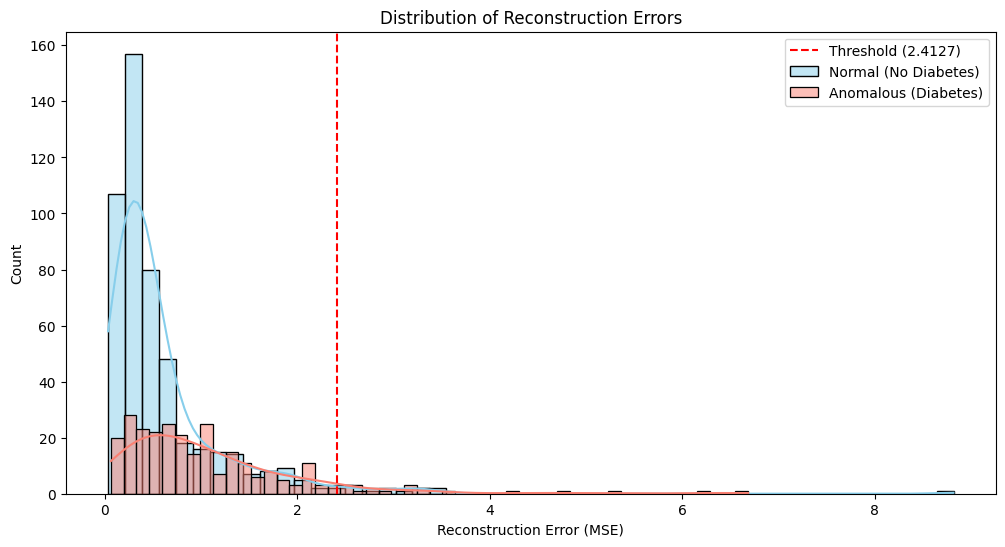

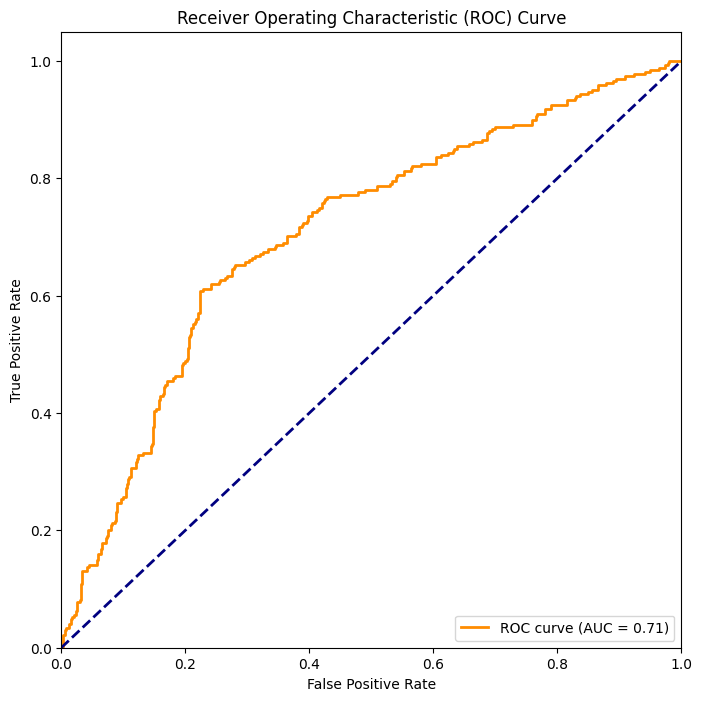


--- Model Performance Metrics ---
Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.97      0.79       500
   Anomalous       0.59      0.07      0.13       268

    accuracy                           0.66       768
   macro avg       0.63      0.52      0.46       768
weighted avg       0.64      0.66      0.56       768

Confusion Matrix:
[[487  13]
 [249  19]]


In [1]:
# Install required libraries
# !pip install -q scikit-learn pandas torch matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. Load and Preprocess Standard Anomaly Dataset
# ==============================================================================
print("1. Loading and preprocessing data...")

# Use the Pima Indians Diabetes Dataset
# The dataset is hosted on a public repository for easy access
file_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
column_names = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
df = pd.read_csv(file_path, names=column_names)

# The 'outcome' column is the target variable (0 for normal, 1 for anomaly)
features = df.drop('outcome', axis=1)
labels = df['outcome']

# Scale the data to improve model performance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split data into training and testing sets
# We train ONLY on 'normal' data (outcome == 0) to teach the autoencoder normal patterns.
X_train_normal = scaled_features[labels == 0]
X_test = scaled_features
y_test = labels.values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("Data preparation complete.")
print(f"Number of training samples (normal data only): {X_train_tensor.shape[0]}")
print(f"Number of testing samples (normal and anomalous): {X_test_tensor.shape[0]}")

# ==============================================================================
# 2. Define the Autoencoder Model
# ==============================================================================
print("\n2. Defining the Autoencoder model...")

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder: 3 layers + bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 6),
            nn.ReLU(True),
            nn.Linear(6, 4),
            nn.ReLU(True),
            nn.Linear(4, 2)  # Bottleneck layer
        )
        # Decoder: from bottleneck to original dim
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(True),
            nn.Linear(4, 6),
            nn.ReLU(True),
            nn.Linear(6, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

# ==============================================================================
# 3. Train the Model
# ==============================================================================
print("\n3. Training the model...")
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        inputs, = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}')
print("Training complete.")

# ==============================================================================
# 4. Anomaly Detection and Evaluation
# ==============================================================================
print("\n4. Performing anomaly detection and evaluation...")

# Get reconstruction errors for the test set
with torch.no_grad():
    model.eval()
    reconstructions = model(X_test_tensor)
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor)**2, dim=1).numpy()

# Set a threshold for classification
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
print(f"Anomaly detection threshold set to: {threshold:.4f}")

# Classify test samples as normal or anomalous
y_pred = (reconstruction_errors > threshold).astype(int)

# ==============================================================================
# 5. Visualize Results
# ==============================================================================

# Plot distribution of reconstruction errors
plt.figure(figsize=(12, 6))
sns.histplot(reconstruction_errors[y_test == 0], bins=50, kde=True, color='skyblue', label='Normal (No Diabetes)')
sns.histplot(reconstruction_errors[y_test == 1], bins=50, kde=True, color='salmon', label='Anomalous (Diabetes)')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot the ROC Curve and calculate AUC
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\n--- Model Performance Metrics ---")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomalous']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

1. Loading and preprocessing data...
Data preparation complete.
Number of training samples (normal data only): 350
Number of testing samples (normal and anomalous): 231

2. Defining the Autoencoder model...
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
  )
)

3. Training the model...
Epoch 10/100, Average Loss: 0.773151
Epoch 20/100, Average Loss: 0.578724
Epoch 30/100, Average Loss: 0.459292
Epoch 40/100, Average Loss: 0.360481
Epoch 50/100, Average Loss: 0.308072
Epoch 60/100, Average Loss: 0.288577
Epoch 70/100, Average Loss: 0.276386
Epoch 80/100, Avera

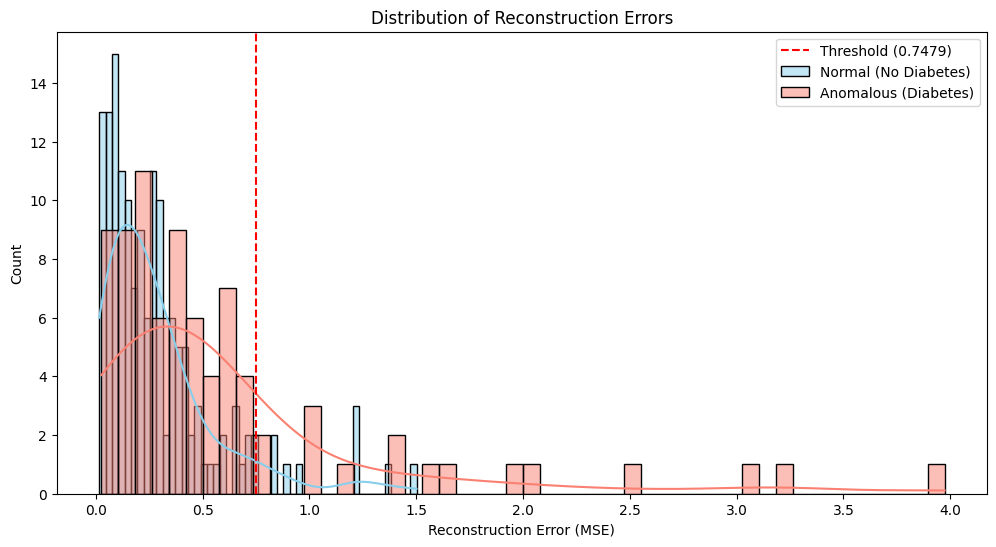

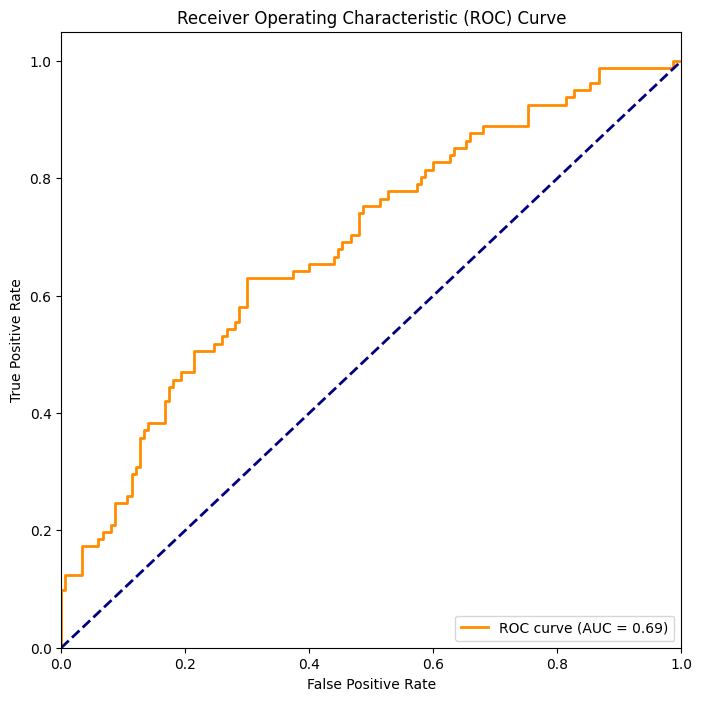


--- Model Performance Metrics ---
Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.93      0.79       150
   Anomalous       0.62      0.20      0.30        81

    accuracy                           0.68       231
   macro avg       0.65      0.57      0.54       231
weighted avg       0.66      0.68      0.62       231

Confusion Matrix:
[[140  10]
 [ 65  16]]


In [2]:
# Install required libraries
# !pip install -q scikit-learn pandas torch matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. Load and Preprocess Standard Anomaly Detection Dataset
# ==============================================================================
print("1. Loading and preprocessing data...")

# Load the Pima Indians Diabetes dataset directly from a public URL.
# The 'outcome' column is the target: 0 for normal, 1 for anomalous (diabetes).
file_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
column_names = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
df = pd.read_csv(file_path, names=column_names)

# Isolate features and labels
features = df.drop('outcome', axis=1)
labels = df['outcome']

# Scale the data using StandardScaler. This is critical for neural networks,
# as it gives features with different scales equal importance.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split the data. We use a standard train/test split but then filter the
# training data to contain ONLY the 'normal' class (outcome == 0).
# The model learns what "normal" looks like, and anything else is an anomaly.
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, labels, test_size=0.3, random_state=42, stratify=labels
)

# Filter the training set to only include normal samples (outcome == 0)
X_train_normal = X_train[y_train == 0]

# Convert the NumPy arrays to PyTorch tensors for model compatibility
X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create a DataLoader for the training set. This efficiently loads data
# in batches during training and shuffles it for better model convergence.
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("Data preparation complete.")
print(f"Number of training samples (normal data only): {X_train_tensor.shape[0]}")
print(f"Number of testing samples (normal and anomalous): {X_test_tensor.shape[0]}")

# ==============================================================================
# 2. Define an Optimized Autoencoder Model
# ==============================================================================
print("\n2. Defining the Autoencoder model...")

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # The encoder compresses the input data into a lower-dimensional latent space.
        # This architecture is designed to be deeper to capture more complex patterns.
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),  # Bottleneck layer: the most compressed representation
        )
        # The decoder attempts to reconstruct the original input from the latent space.
        # It is a mirror image of the encoder to reverse the compression.
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer.
# The Mean Squared Error (MSELoss) is perfect for reconstruction tasks.
# Adam optimizer is a robust choice for deep learning models.
input_dim = X_train_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

# ==============================================================================
# 3. Train the Model
# ==============================================================================
print("\n3. Training the model...")

# Set number of epochs for training
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train() # Set the model to training mode
    total_loss = 0
    for data in train_loader:
        inputs, = data

        # Forward pass: compute the model's output
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass: compute gradients and update weights
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()      # Compute gradients
        optimizer.step()     # Update model weights

        total_loss += loss.item()

    # Print average loss for the epoch to track progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.6f}')

print("Training complete.")

# ==============================================================================
# 4. Anomaly Detection and Evaluation
# ==============================================================================
print("\n4. Performing anomaly detection and evaluation...")

# Switch to evaluation mode to disable layers like dropout.
model.eval()

# Calculate reconstruction errors for the entire test set.
# The reconstruction error is the model's primary anomaly score.
with torch.no_grad():
    reconstructions = model(X_test_tensor)
    reconstruction_errors = torch.mean((reconstructions - X_test_tensor)**2, dim=1).numpy()

# Set a dynamic threshold based on the reconstruction errors of the training data.
# This is a robust way to classify a new sample as an anomaly if its error
# is statistically significant compared to what the model considers 'normal'.
with torch.no_grad():
    train_reconstructions = model(X_train_tensor)
    train_errors = torch.mean((train_reconstructions - X_train_tensor)**2, dim=1).numpy()

# Set the threshold as the 95th percentile of the training errors.
# This means only 5% of the normal training data would be classified as anomalous.
threshold = np.percentile(train_errors, 95)
print(f"Anomaly detection threshold set to the 95th percentile of training errors: {threshold:.4f}")

# Classify test samples as normal (0) or anomalous (1) based on the threshold.
y_pred = (reconstruction_errors > threshold).astype(int)

# ==============================================================================
# 5. Visualize and Report Results
# ==============================================================================
print("\n5. Visualizing and reporting results...")

# Plot the distribution of reconstruction errors for normal vs. anomalous data.
# This visualizes how well the model separates the two classes.
plt.figure(figsize=(12, 6))
sns.histplot(reconstruction_errors[y_test == 0], bins=50, kde=True, color='skyblue', label='Normal (No Diabetes)')
sns.histplot(reconstruction_errors[y_test == 1], bins=50, kde=True, color='salmon', label='Anomalous (Diabetes)')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot the ROC Curve to evaluate the model's overall performance.
# The ROC curve shows the trade-off between the True Positive Rate and False Positive Rate.
# A curve closer to the top-left corner indicates better performance.
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print detailed performance metrics.
# The classification report provides precision, recall, and F1-score.
# The confusion matrix shows the number of correct and incorrect classifications.
print("\n--- Model Performance Metrics ---")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomalous']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Loading and preprocessing dataset...
Training samples (normal only): 900
Testing samples (all): 1000

Training the autoencoder...
Epoch 1, Loss: 0.9486
Epoch 2, Loss: 0.9495
Epoch 3, Loss: 0.9284
Epoch 4, Loss: 0.9090
Epoch 5, Loss: 0.8828
Epoch 6, Loss: 0.8421
Epoch 7, Loss: 0.8041
Epoch 8, Loss: 0.7681
Epoch 9, Loss: 0.7364
Epoch 10, Loss: 0.7208
Epoch 11, Loss: 0.7194
Epoch 12, Loss: 0.6738
Epoch 13, Loss: 0.6462
Epoch 14, Loss: 0.6386
Epoch 15, Loss: 0.6256
Epoch 16, Loss: 0.6193
Epoch 17, Loss: 0.6207
Epoch 18, Loss: 0.6060
Epoch 19, Loss: 0.6050
Epoch 20, Loss: 0.5994
Epoch 21, Loss: 0.5828
Epoch 22, Loss: 0.5653
Epoch 23, Loss: 0.5496
Epoch 24, Loss: 0.5224
Epoch 25, Loss: 0.5164
Epoch 26, Loss: 0.4964
Epoch 27, Loss: 0.4784
Epoch 28, Loss: 0.4826
Epoch 29, Loss: 0.4708
Epoch 30, Loss: 0.4637
Training complete.

Detecting anomalies...
Anomaly threshold: 0.7670

--- Model Performance ---
Classification Report:
              precision    recall  f1-score   support

         0.0   

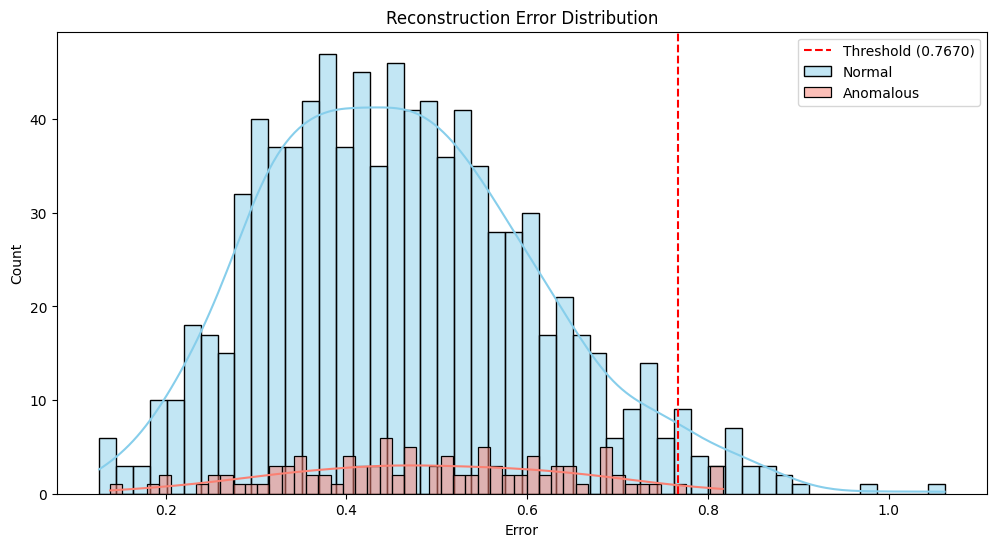

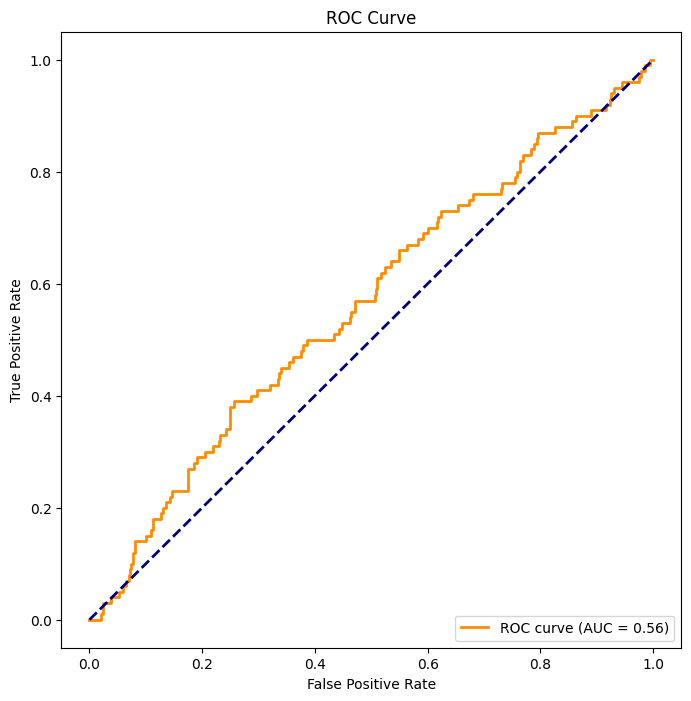

In [10]:
# ==============================================================================
# 0. Install Required Libraries (Uncomment if needed)
# ==============================================================================
# !pip install pandas numpy scikit-learn torch matplotlib seaborn requests

# ==============================================================================
# 1. Import Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 2. Load and Preprocess Dataset
# ==============================================================================
print("Loading and preprocessing dataset...")

url = 'https://raw.githubusercontent.com/Professor-Marrah/AI_Network_Traffic_Anomaly_Detection/master/embedded_system_network_security_dataset.csv'
df = pd.read_csv(url)

# Check for missing values
df.dropna(inplace=True)

# Assume 'label' column exists: 0 = normal, 1 = anomaly
features = df.drop('label', axis=1)
labels = df['label']

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split data
X_train = scaled_features[labels == 0]  # train only on normal data
X_test = scaled_features
y_test = labels.values

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

print(f"Training samples (normal only): {X_train_tensor.shape[0]}")
print(f"Testing samples (all): {X_test_tensor.shape[0]}")

# ==============================================================================
# 3. Define Autoencoder Model
# ==============================================================================
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================================================================
# 4. Train the Autoencoder
# ==============================================================================
print("\nTraining the autoencoder...")
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, = batch
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
print("Training complete.")

# ==============================================================================
# 5. Detect Anomalies
# ==============================================================================
print("\nDetecting anomalies...")
model.eval()
with torch.no_grad():
    reconstructions = model(X_test_tensor)
    errors = torch.mean((reconstructions - X_test_tensor)**2, dim=1).numpy()

threshold = np.mean(errors) + 2 * np.std(errors)
print(f"Anomaly threshold: {threshold:.4f}")
y_pred = (errors > threshold).astype(int)

# ==============================================================================
# 6. Evaluate Performance
# ==============================================================================
print("\n--- Model Performance ---")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ==============================================================================
# 7. Visualize Results
# ==============================================================================
plt.figure(figsize=(12, 6))
sns.histplot(errors[y_test == 0], bins=50, kde=True, color='skyblue', label='Normal')
sns.histplot(errors[y_test == 1], bins=50, kde=True, color='salmon', label='Anomalous')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Loading and preprocessing dataset...

Training the autoencoder...
Epoch 1, Train Loss: 0.9483, Val Loss: 0.9320
Epoch 2, Train Loss: 0.9342, Val Loss: 0.9169
Epoch 3, Train Loss: 0.9163, Val Loss: 0.8853
Epoch 4, Train Loss: 0.8660, Val Loss: 0.8365
Epoch 5, Train Loss: 0.8186, Val Loss: 0.7846
Epoch 6, Train Loss: 0.7543, Val Loss: 0.7226
Epoch 7, Train Loss: 0.6820, Val Loss: 0.6648
Epoch 8, Train Loss: 0.6141, Val Loss: 0.6109
Epoch 9, Train Loss: 0.5679, Val Loss: 0.5673
Epoch 10, Train Loss: 0.5202, Val Loss: 0.5362
Epoch 11, Train Loss: 0.4890, Val Loss: 0.5080
Epoch 12, Train Loss: 0.4653, Val Loss: 0.4917
Epoch 13, Train Loss: 0.4433, Val Loss: 0.4750
Epoch 14, Train Loss: 0.4217, Val Loss: 0.4453
Epoch 15, Train Loss: 0.3898, Val Loss: 0.4140
Epoch 16, Train Loss: 0.3634, Val Loss: 0.3908
Epoch 17, Train Loss: 0.3446, Val Loss: 0.3696
Epoch 18, Train Loss: 0.3164, Val Loss: 0.3424
Epoch 19, Train Loss: 0.2932, Val Loss: 0.3231
Epoch 20, Train Loss: 0.2823, Val Loss: 0.3155
Epo

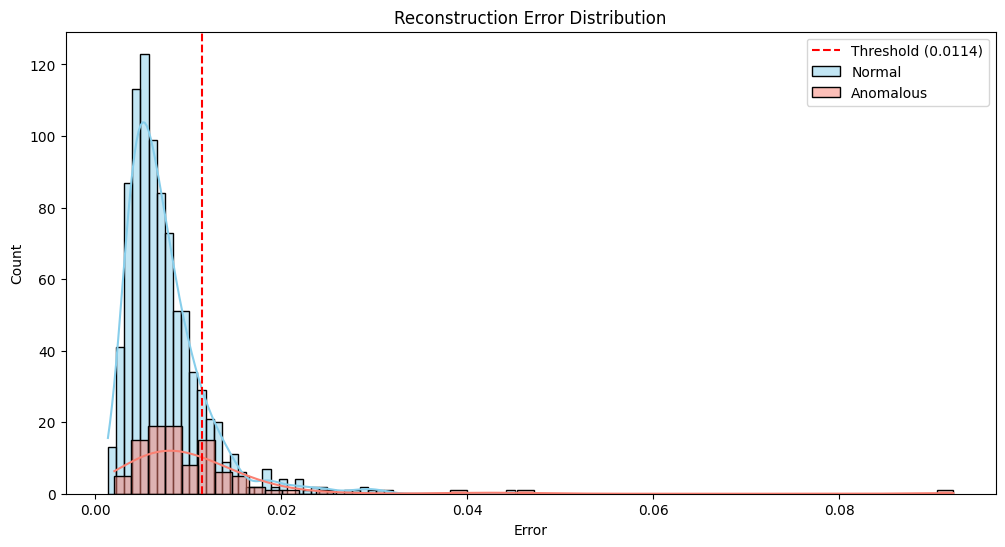

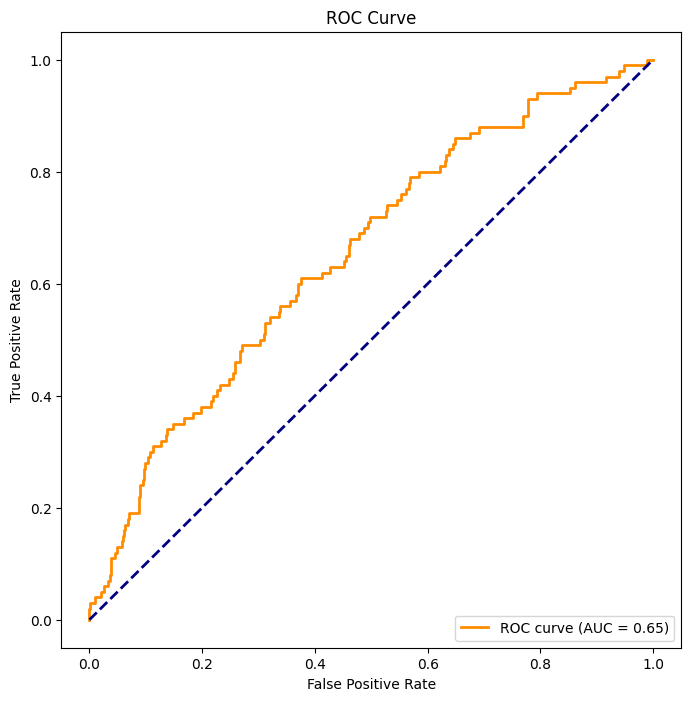

In [11]:
# ==============================================================================
# 0. Install Required Libraries (Uncomment if needed)
# ==============================================================================
# !pip install pandas numpy scikit-learn torch matplotlib seaborn requests

# ==============================================================================
# 1. Import Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ==============================================================================
# 2. Load and Preprocess Dataset
# ==============================================================================
print("Loading and preprocessing dataset...")

url = 'https://raw.githubusercontent.com/Professor-Marrah/AI_Network_Traffic_Anomaly_Detection/master/embedded_system_network_security_dataset.csv'
df = pd.read_csv(url)
df.dropna(inplace=True)

features = df.drop('label', axis=1)
labels = df['label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split normal data into train/val
X_normal = scaled_features[labels == 0]
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

X_test = scaled_features
y_test = labels.values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

# ==============================================================================
# 3. Define Improved Autoencoder Model
# ==============================================================================
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================================================================
# 4. Train with Early Stopping
# ==============================================================================
print("\nTraining the autoencoder...")
best_val_loss = float('inf')
patience = 5
wait = 0
epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, = batch
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, X_val_tensor).item()

    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

print("Training complete.")

# ==============================================================================
# 5. Optimize Threshold Using F1 Score
# ==============================================================================
print("\nOptimizing threshold...")
model.eval()
with torch.no_grad():
    reconstructions = model(X_test_tensor)
    errors = torch.mean((reconstructions - X_test_tensor)**2, dim=1).numpy()

best_f1 = 0
best_thresh = 0
for t in np.linspace(min(errors), max(errors), 100):
    preds = (errors > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Optimal threshold: {best_thresh:.4f}, Best F1 Score: {best_f1:.4f}")
y_pred = (errors > best_thresh).astype(int)

# ==============================================================================
# 6. Evaluate Performance
# ==============================================================================
print("\n--- Model Performance ---")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ==============================================================================
# 7. Visualize Results
# ==============================================================================
plt.figure(figsize=(12, 6))
sns.histplot(errors[y_test == 0], bins=50, kde=True, color='skyblue', label='Normal')
sns.histplot(errors[y_test == 1], bins=50, kde=True, color='salmon', label='Anomalous')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Threshold ({best_thresh:.4f})')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Loading dataset...
Scaled features: 17 -> PCA components: 16 (variance=0.99)

Training AE on PCA space...
Epoch 001 | Train Loss: 1.080533 | Val Loss: 0.988676
Epoch 002 | Train Loss: 0.831136 | Val Loss: 0.978517
Epoch 003 | Train Loss: 0.685610 | Val Loss: 0.953923
Epoch 004 | Train Loss: 0.593283 | Val Loss: 0.908801
Epoch 005 | Train Loss: 0.505167 | Val Loss: 0.837280
Epoch 006 | Train Loss: 0.446015 | Val Loss: 0.736865
Epoch 007 | Train Loss: 0.398598 | Val Loss: 0.619931
Epoch 008 | Train Loss: 0.363947 | Val Loss: 0.505332
Epoch 009 | Train Loss: 0.336255 | Val Loss: 0.406623
Epoch 010 | Train Loss: 0.313005 | Val Loss: 0.327500
Epoch 011 | Train Loss: 0.283740 | Val Loss: 0.268847
Epoch 012 | Train Loss: 0.267688 | Val Loss: 0.226328
Epoch 013 | Train Loss: 0.260949 | Val Loss: 0.196237
Epoch 014 | Train Loss: 0.243352 | Val Loss: 0.173322
Epoch 015 | Train Loss: 0.233126 | Val Loss: 0.157083
Epoch 016 | Train Loss: 0.222000 | Val Loss: 0.142957
Epoch 017 | Train Loss: 0.2154

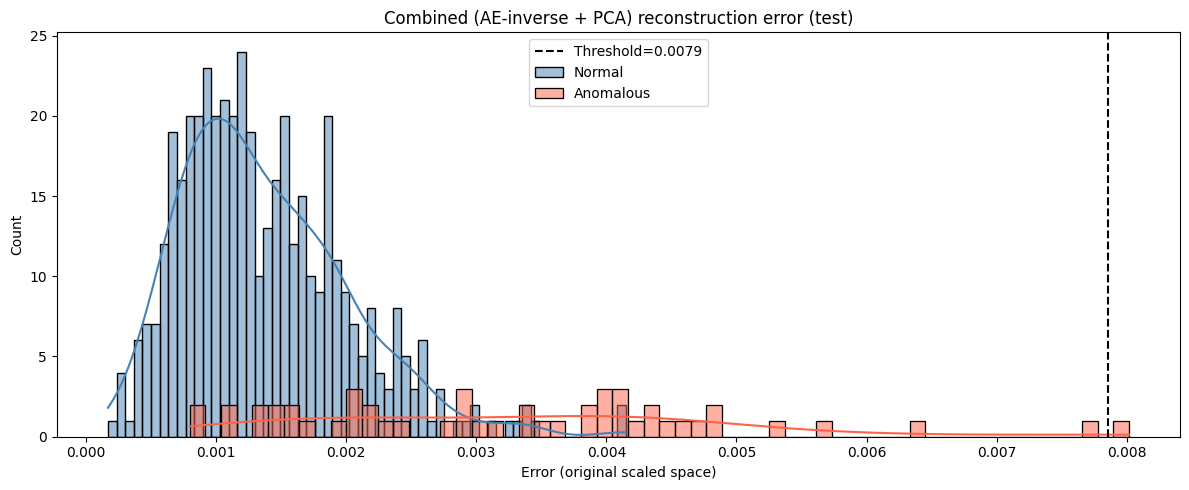

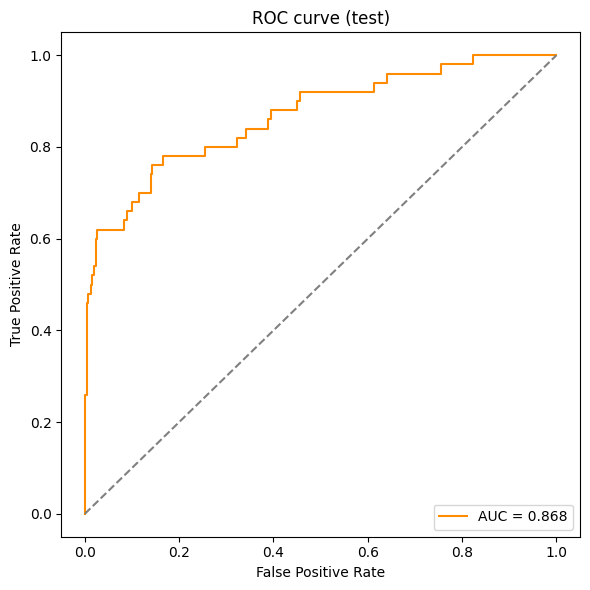

In [19]:
# ==============================================================================
# 0) Install (uncomment if needed)
# ==============================================================================
# !pip install pandas numpy scikit-learn torch matplotlib seaborn

# ==============================================================================
# 1) Imports and config
# ==============================================================================
import os, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================================================================
# 2) Load data
# ==============================================================================
print("Loading dataset...")
url = "https://raw.githubusercontent.com/Professor-Marrah/AI_Network_Traffic_Anomaly_Detection/master/embedded_system_network_security_dataset.csv"
df = pd.read_csv(url).dropna().reset_index(drop=True)

y_all = df["label"].astype(int).values
X_df = df.drop(columns=["label"])

# ==============================================================================
# 3) Split sets: normal-only train/val for learning; stratified val/test for thresholding/eval
# ==============================================================================
normal_mask = (y_all == 0)
X_norm_df = X_df[normal_mask]
if len(X_norm_df) < 200:
    raise RuntimeError("Not enough normal rows for training. Reduce complexity or check data.")

X_train_df, X_valnorm_df = train_test_split(
    X_norm_df, test_size=0.2, random_state=SEED, shuffle=True
)

# Stratified split on ALL rows for threshold tuning and final testing
X_valall_df, X_test_df, y_valall, y_test = train_test_split(
    X_df, y_all, test_size=0.5, random_state=SEED, stratify=y_all
)

# ==============================================================================
# 4) Scale with train-normal only (avoid leakage)
# ==============================================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df).astype(np.float32)
X_valnorm = scaler.transform(X_valnorm_df).astype(np.float32)
X_valall = scaler.transform(X_valall_df).astype(np.float32)
X_test = scaler.transform(X_test_df).astype(np.float32)

# ==============================================================================
# 5) PCA on train-normal, keep desired variance
# ==============================================================================
from sklearn.decomposition import PCA

VAR_RETAIN = 0.99  # try 0.95–0.999; higher retains more info
pca = PCA(n_components=VAR_RETAIN, svd_solver="full", random_state=SEED)
Z_train = pca.fit_transform(X_train).astype(np.float32)
Z_valnorm = pca.transform(X_valnorm).astype(np.float32)
Z_valall = pca.transform(X_valall).astype(np.float32)
Z_test = pca.transform(X_test).astype(np.float32)

n_features = X_train.shape[1]
n_z = Z_train.shape[1]
print(f"Scaled features: {n_features} -> PCA components: {n_z} (variance={VAR_RETAIN})")

# Baseline PCA-only reconstruction errors (for optional ensemble)
X_valall_pca_recon = pca.inverse_transform(Z_valall)
X_test_pca_recon = pca.inverse_transform(Z_test)
pca_val_err = np.mean((X_valall - X_valall_pca_recon) ** 2, axis=1)
pca_test_err = np.mean((X_test - X_test_pca_recon) ** 2, axis=1)

# ==============================================================================
# 6) Autoencoder on PCA space (denoising, BN+Dropout)
# ==============================================================================
class AEonPCA(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, max(256, 4*input_dim)),
            nn.BatchNorm1d(max(256, 4*input_dim)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(max(256, 4*input_dim), max(128, 2*input_dim)),
            nn.BatchNorm1d(max(128, 2*input_dim)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(max(128, 2*input_dim), max(64, input_dim//2)),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(max(64, input_dim//2), max(128, 2*input_dim)),
            nn.BatchNorm1d(max(128, 2*input_dim)),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(max(128, 2*input_dim), max(256, 4*input_dim)),
            nn.BatchNorm1d(max(256, 4*input_dim)),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(max(256, 4*input_dim), input_dim),
        )

    def forward(self, z):
        return self.decoder(self.encoder(z))

model = AEonPCA(n_z).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=4)

BATCH_SIZE = 256
EPOCHS = 150
PATIENCE = 12
NOISE_STD = 0.02
GRAD_CLIP = 1.0

def add_noise(x, std):
    return x + torch.randn_like(x) * std if std > 0 else x

train_loader = DataLoader(TensorDataset(torch.tensor(Z_train)), batch_size=BATCH_SIZE, shuffle=True)
Z_valnorm_t = torch.tensor(Z_valnorm, dtype=torch.float32).to(device)

best_val, best_state, wait = float("inf"), None, 0
print("\nTraining AE on PCA space...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    tlosses = []
    for (zb,) in train_loader:
        zb = zb.to(device)
        zb_noisy = add_noise(zb, NOISE_STD)
        zhat = model(zb_noisy)
        loss = criterion(zhat, zb)
        optimizer.zero_grad()
        loss.backward()
        if GRAD_CLIP:
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        tlosses.append(loss.item())

    model.eval()
    with torch.no_grad():
        zhat_val = model(Z_valnorm_t)
        val_loss = criterion(zhat_val, Z_valnorm_t).item()

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {np.mean(tlosses):.6f} | Val Loss: {val_loss:.6f}")

    if val_loss + 1e-7 < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)
model.to(device)
print("Training complete.")

# ==============================================================================
# 7) Compute errors in ORIGINAL space via inverse PCA (sharper separation)
# ==============================================================================
@torch.no_grad()
def ae_errors_original_space(m, Z, X_true, batch=4096):
    m.eval()
    errs = []
    for i in range(0, Z.shape[0], batch):
        z = torch.tensor(Z[i:i+batch], dtype=torch.float32, device=device)
        zhat = m(z).cpu().numpy()
        xhat = pca.inverse_transform(zhat)   # back to original scaled feature space
        e = np.mean((X_true[i:i+batch] - xhat) ** 2, axis=1)
        errs.append(e)
    return np.concatenate(errs, axis=0)

ae_val_err = ae_errors_original_space(model, Z_valall, X_valall)
ae_test_err = ae_errors_original_space(model, Z_test, X_test)

# ==============================================================================
# 8) Ensemble of AE+PCA errors (tuned on validation to maximize accuracy)
# ==============================================================================
def tune_alpha_and_threshold(val_err_ae, val_err_pca, y_val, metric="acc"):
    alphas = np.linspace(0.0, 1.0, 11)  # 0.0 => PCA-only, 1.0 => AE-only
    best = {"alpha": None, "thr": None, "acc": -1, "f1": -1}
    for a in alphas:
        comb = a * val_err_ae + (1 - a) * val_err_pca
        # scan thresholds on quantiles to be robust
        cands = np.quantile(comb, np.linspace(0.01, 0.99, 199))
        for t in cands:
            preds = (comb > t).astype(int)
            acc = accuracy_score(y_val, preds)
            f1 = f1_score(y_val, preds, zero_division=0)
            score = acc if metric == "acc" else f1
            if score > best[metric]:
                best = {"alpha": a, "thr": t, "acc": acc, "f1": f1}
    return best

best = tune_alpha_and_threshold(ae_val_err, pca_val_err, y_valall, metric="acc")
print(f"\nValidation tuning | alpha={best['alpha']:.2f} (1=AE), thr={best['thr']:.6f}, "
      f"ACC={best['acc']*100:.2f}%, F1={best['f1']:.4f}")

alpha = best["alpha"]
thr = best["thr"]

comb_test_err = alpha * ae_test_err + (1 - alpha) * pca_test_err
y_pred = (comb_test_err > thr).astype(int)

# ==============================================================================
# 9) Final evaluation
# ==============================================================================
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, zero_division=0)
print(f"\nTest | Accuracy: {acc*100:.2f}% | F1: {f1:.4f}")
print("\n--- Classification Report (Test) ---")
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomalous"], zero_division=0))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred))

# ==============================================================================
# 10) Visualizations
# ==============================================================================
plt.figure(figsize=(12, 5))
sns.histplot(comb_test_err[y_test == 0], bins=60, kde=True, color="steelblue", label="Normal")
sns.histplot(comb_test_err[y_test == 1], bins=60, kde=True, color="tomato", label="Anomalous")
plt.axvline(thr, color="black", ls="--", label=f"Threshold={thr:.4f}")
plt.title("Combined (AE-inverse + PCA) reconstruction error (test)")
plt.xlabel("Error (original scaled space)"); plt.ylabel("Count")
plt.legend(); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, comb_test_err)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], ls="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curve (test)")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

# ==============================================================================
# 11) Quick knobs to push accuracy higher
# ==============================================================================
# - Increase VAR_RETAIN to 0.995–0.999 (richer PCA basis) and retrain.
# - Widen AE hidden sizes or depth for more capacity.
# - Tune NOISE_STD in [0.00, 0.08]; denoising often sharpens separation.
# - Change validation metric in tune_alpha_and_threshold to "f1" for class-imbalance robustness.
# - If you can sort rows by a time/session field, switch to LSTM AE with sliding windows on PCA space.